In [23]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, precision_score, 
                           recall_score, f1_score, accuracy_score, average_precision_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import joblib
import pickle
from datetime import datetime
from math import pi

# Visualization Settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(" Environment setup complete!")

 Environment setup complete!


In [24]:
def load_data(dataset_path, data_dict_path=None):
    """Load dataset and data dictionary"""
    try:
        # Load main dataset
        df = pd.read_csv(dataset_path)
        print(f" Successfully loaded dataset from: {dataset_path}")
        
        # Load data dictionary if provided
        data_dict = None
        if data_dict_path:
            try:
                data_dict = pd.read_csv(data_dict_path)
                print(f" Successfully loaded data dictionary from: {data_dict_path}")
            except:
                print(f" Could not load data dictionary from: {data_dict_path}")
        
        return df, data_dict
    except Exception as e:
        print(f" Error loading data: {e}")
        return None, None

# UPDATE THIS PATH TO YOUR CSV FILE LOCATION
DATASET_PATH = "Dataset.csv"  # Update this path
DATA_DICT_PATH = "Data_Dictionary.csv"  # Update this path (optional)

# Load data
df, data_dict = load_data(DATASET_PATH, DATA_DICT_PATH)

if df is not None:
    print("\nDATASET OVERVIEW")
    print("=" * 50)
    print(f"Dataset Shape: {df.shape}")
    print(f"Features: {df.shape[1]}")
    print(f"Records: {df.shape[0]:,}")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Display first few rows
    print("\n SAMPLE DATA:")
    print(df.head())
    
    # Display data types
    print("\n DATA TYPES:")
    print(df.dtypes)
    
    # Show data dictionary if available
    if data_dict is not None:
        print("\n DATA DICTIONARY:")
        print(data_dict.head(10))
else:
    print(" Failed to load dataset. Please check the file path.")

 Successfully loaded dataset from: Dataset.csv
 Successfully loaded data dictionary from: Data_Dictionary.csv

DATASET OVERVIEW
Dataset Shape: (121856, 40)
Features: 40
Records: 121,856
Memory Usage: 152.02 MB

 SAMPLE DATA:
         ID Client_Income  Car_Owned  Bike_Owned  Active_Loan  House_Own  Child_Count Credit_Amount Loan_Annuity Accompany_Client Client_Income_Type    Client_Education Client_Marital_Status Client_Gender Loan_Contract_Type Client_Housing_Type Population_Region_Relative Age_Days Employed_Days Registration_Days ID_Days  Own_House_Age  Mobile_Tag  Homephone_Tag  Workphone_Working Client_Occupation  Client_Family_Members  Cleint_City_Rating  Application_Process_Day  Application_Process_Hour Client_Permanent_Match_Tag Client_Contact_Work_Tag       Type_Organization  Score_Source_1  Score_Source_2 Score_Source_3  Social_Circle_Default  Phone_Change  Credit_Bureau  Default
0  12142509          6750        0.0         0.0          1.0        0.0          0.0      61190.55

In [25]:
def enhanced_correlation_analysis(df, target_col='Default'):
    """Enhanced correlation analysis with feature selection insights"""
    
    # Convert categorical to numerical for correlation
    df_corr = df.copy()
    categorical_cols = df_corr.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        if col != target_col:
            le = LabelEncoder()
            df_corr[col] = le.fit_transform(df_corr[col].astype(str))
    
    # Calculate correlation matrix
    correlation_matrix = df_corr.corr()
    
    # Feature correlation with target
    target_corr = correlation_matrix[target_col].abs().sort_values(ascending=False)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # 1. Correlation heatmap
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix.iloc[:20, :20], mask=mask[:20, :20], 
                annot=True, fmt='.2f', ax=axes[0], cmap='RdBu_r', center=0)
    axes[0].set_title('Feature Correlation Matrix (Top 20)', fontweight='bold')
    
    # 2. Target correlation
    top_corr = target_corr.head(15)
    top_corr.plot(kind='barh', ax=axes[1])
    axes[1].set_title('Top 15 Features Correlated with Default', fontweight='bold')
    axes[1].set_xlabel('Absolute Correlation')
    
    # 3. Multicollinearity detection
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append({
                    'Feature1': correlation_matrix.columns[i],
                    'Feature2': correlation_matrix.columns[j],
                    'Correlation': correlation_matrix.iloc[i, j]
                })
    
    if high_corr_pairs:
        multicollinearity_text = "High Correlation Pairs (>0.8):\n\n"
        for pair in high_corr_pairs[:10]:
            multicollinearity_text += f"{pair['Feature1']} - {pair['Feature2']}: {pair['Correlation']:.3f}\n"
    else:
        multicollinearity_text = "No high multicollinearity detected\n(correlation > 0.8)"
    
    axes[2].text(0.1, 0.9, multicollinearity_text, transform=axes[2].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace')
    axes[2].set_title('Multicollinearity Analysis', fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return target_corr, high_corr_pairs

def compare_imbalance_techniques(X, y):
    """Compare different imbalance handling techniques"""
    
    techniques = {
        'Original': (X, y),
        'SMOTE': SMOTE(random_state=42).fit_resample(X, y),
        'BorderlineSMOTE': BorderlineSMOTE(random_state=42).fit_resample(X, y),
        'ADASYN': ADASYN(random_state=42).fit_resample(X, y)
    }
    
    results = []
    for name, (X_resampled, y_resampled) in techniques.items():
        # Quick model evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
        )
        
        rf = RandomForestClassifier(n_estimators=50, random_state=42)
        rf.fit(X_train, y_train)
        y_pred_proba = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        
        results.append({
            'Technique': name,
            'Class_0_Count': sum(y_resampled == 0),
            'Class_1_Count': sum(y_resampled == 1),
            'Imbalance_Ratio': sum(y_resampled == 0) / sum(y_resampled == 1),
            'Test_AUC': auc,
            'Total_Samples': len(y_resampled)
        })
    
    comparison_df = pd.DataFrame(results)
    print(" IMBALANCE TECHNIQUE COMPARISON:")
    print(comparison_df.round(3))
    
    return comparison_df

def advanced_feature_importance(model, X, y, feature_names):
    """Advanced feature importance with permutation importance"""
    
    # Get model-based importance
    if hasattr(model, 'feature_importances_'):
        model_importance = model.feature_importances_
    else:
        model_importance = np.zeros(len(feature_names))
    
    # Calculate permutation importance
    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Model_Importance': model_importance,
        'Permutation_Importance': perm_importance.importances_mean,
        'Permutation_Std': perm_importance.importances_std
    }).sort_values('Permutation_Importance', ascending=False)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top 15 features by permutation importance
    top_features = importance_df.head(15)
    
    axes[0].barh(range(len(top_features)), top_features['Permutation_Importance'],
                xerr=top_features['Permutation_Std'])
    axes[0].set_yticks(range(len(top_features)))
    axes[0].set_yticklabels(top_features['Feature'])
    axes[0].set_xlabel('Permutation Importance')
    axes[0].set_title('Top 15 Features - Permutation Importance', fontweight='bold')
    axes[0].invert_yaxis()
    
    # Comparison: Model vs Permutation importance
    axes[1].scatter(top_features['Model_Importance'], top_features['Permutation_Importance'])
    for i, row in top_features.iterrows():
        axes[1].annotate(row['Feature'][:10], 
                        (row['Model_Importance'], row['Permutation_Importance']),
                        fontsize=8, alpha=0.7)
    axes[1].set_xlabel('Model-based Importance')
    axes[1].set_ylabel('Permutation Importance')
    axes[1].set_title('Model vs Permutation Importance', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

def model_interpretation_summary(best_model, X, feature_names, top_n=10):
    """Provide business-friendly model interpretation"""
    
    if hasattr(best_model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print(" MODEL INTERPRETATION FOR BUSINESS:")
        print("=" * 50)
        print("Top Risk Factors (in order of importance):")
        
        for i, (_, row) in enumerate(importance_df.head(top_n).iterrows(), 1):
            importance_pct = row['Importance'] * 100
            print(f"{i:2d}. {row['Feature']}: {importance_pct:.1f}% influence")
        
        # Business recommendations
        print(f"\n BUSINESS RECOMMENDATIONS:")
        print("1. Focus manual review on applications with high-risk factor combinations")
        print("2. Create automated flags for top 5 risk factors")
        print("3. Develop specialized questionnaires for medium-risk applications")
        print("4. Implement real-time risk scoring based on these factors")
        
        return importance_df
    else:
        print(" Feature importance not available for this model type")
        return None

def optimize_business_threshold(y_test, y_pred_proba):
    """Find optimal threshold based on business metrics"""
    
    thresholds = np.linspace(0.1, 0.9, 81)
    results = []
    
    # Business assumptions
    avg_loan_amount = 50000
    default_loss_rate = 0.6  # 60% loss on defaulted loans
    profit_margin = 0.05     # 5% profit on good loans
    manual_review_cost = 500 # Cost to manually review an application
    
    for threshold in thresholds:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        
        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
        
        # Business calculations
        revenue_lost = fp * avg_loan_amount * profit_margin
        losses_prevented = tp * avg_loan_amount * default_loss_rate
        actual_losses = fn * avg_loan_amount * default_loss_rate
        review_costs = (fp + tp) * manual_review_cost
        
        net_benefit = losses_prevented - revenue_lost - actual_losses - review_costs
        
        # Metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'net_benefit': net_benefit,
            'approval_rate': (tn + fp) / len(y_test),
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
        })
    
    results_df = pd.DataFrame(results)
    optimal_idx = results_df['net_benefit'].idxmax()
    optimal_threshold = results_df.loc[optimal_idx, 'threshold']
    
    print(f" OPTIMAL BUSINESS THRESHOLD: {optimal_threshold:.3f}")
    print(f"   Maximum Net Benefit: ${results_df.loc[optimal_idx, 'net_benefit']:,.0f}")
    print(f"   Precision: {results_df.loc[optimal_idx, 'precision']:.3f}")
    print(f"   Recall: {results_df.loc[optimal_idx, 'recall']:.3f}")
    print(f"   Approval Rate: {results_df.loc[optimal_idx, 'approval_rate']:.1%}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    axes[0].plot(results_df['threshold'], results_df['net_benefit'], 'b-', linewidth=2)
    axes[0].axvline(optimal_threshold, color='red', linestyle='--', alpha=0.7)
    axes[0].set_xlabel('Threshold')
    axes[0].set_ylabel('Net Benefit ($)')
    axes[0].set_title('Net Business Benefit by Threshold', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(results_df['approval_rate'], results_df['precision'], 'g-', linewidth=2)
    axes[1].scatter(results_df.loc[optimal_idx, 'approval_rate'], 
                   results_df.loc[optimal_idx, 'precision'], 
                   color='red', s=100, zorder=5)
    axes[1].set_xlabel('Approval Rate')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Approval Rate vs Precision Trade-off', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return optimal_threshold, results_df

def print_system_design_overview():
    """Print comprehensive system design considerations"""
    
    print("\n" + "=" * 60)
    print("                    SYSTEM DESIGN ARCHITECTURE")
    print("=" * 60)
    
    architecture_components = {
        " Real-time Prediction API": [
            "FastAPI/Flask REST endpoint for loan applications",
            "Input validation and preprocessing pipeline",
            "Model inference with confidence scores",
            "Response with risk level and recommendation"
        ],
        
        " Batch Processing System": [
            "Daily/weekly batch scoring for existing portfolio",
            "ETL pipeline for data ingestion and transformation",
            "Distributed processing using Apache Spark/Dask",
            "Results storage in data warehouse"
        ],
        
        " Model Monitoring": [
            "Data drift detection using KL divergence/PSI",
            "Model performance tracking (AUC, precision, recall)",
            "Feature distribution monitoring",
            "Alert system for performance degradation"
        ],
        
        " MLOps Pipeline": [
            "Automated retraining triggers based on performance thresholds",
            "Model versioning with experiment tracking (MLflow)",
            "A/B testing framework for model comparison",
            "CI/CD pipeline with model validation gates"
        ],
        
        " Security & Compliance": [
            "Data encryption at rest and in transit",
            "Audit logging for all predictions",
            "GDPR compliance for data handling",
            "Model explainability for regulatory requirements"
        ],
        
        " Scalability": [
            "Horizontal scaling with load balancers",
            "Caching layer for feature computation",
            "Database optimization for high-throughput",
            "Auto-scaling based on prediction volume"
        ]
    }
    
    for component, details in architecture_components.items():
        print(f"\n{component}:")
        for detail in details:
            print(f"  • {detail}")
    
    print(f"\n KEY TECHNICAL DECISIONS:")
    print("• Microservices architecture for modularity")
    print("• Event-driven processing for real-time updates")
    print("• Feature store for consistent feature engineering")
    print("• Model registry for version control")
    print("• Monitoring dashboard for business stakeholders")

print(" Enhanced analysis functions loaded successfully!")

 Enhanced analysis functions loaded successfully!



EXPLORATORY DATA ANALYSIS


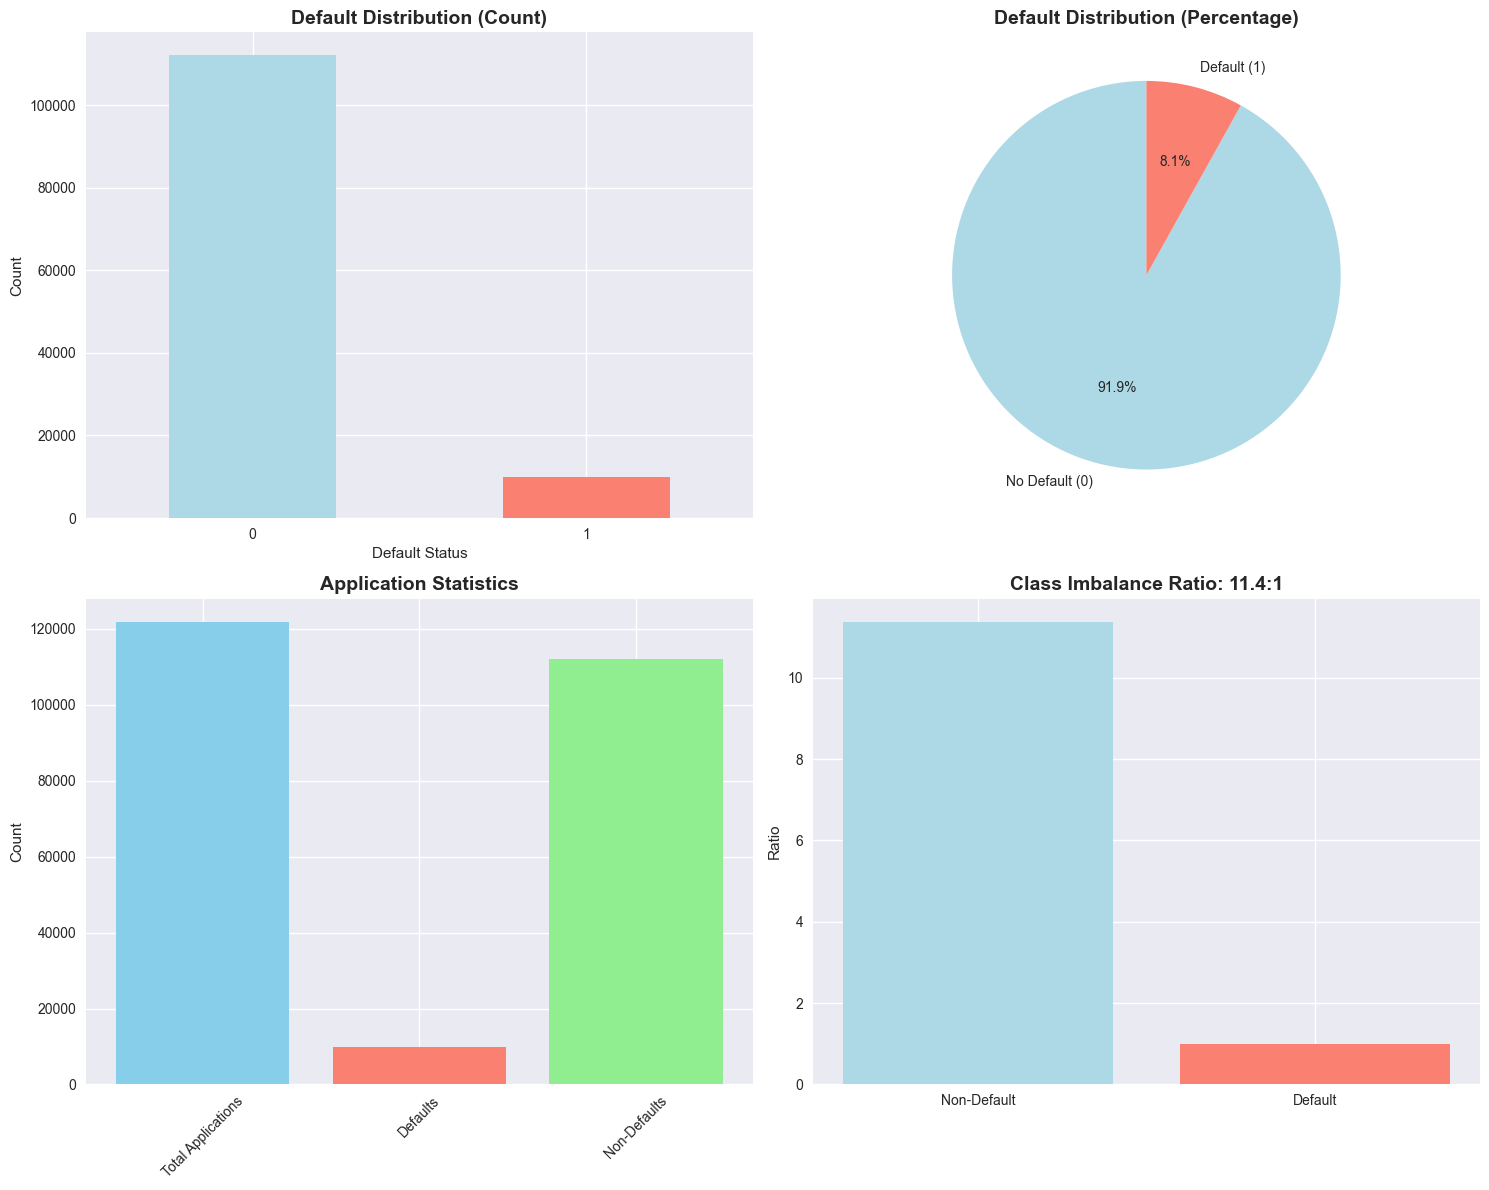

 KEY STATISTICS:
   Default Rate: 8.08%
   Class Imbalance: 11.4:1 (Non-Default:Default)
   Total Applications: 121,856
   Defaults: 9,845
   Non-Defaults: 112,011


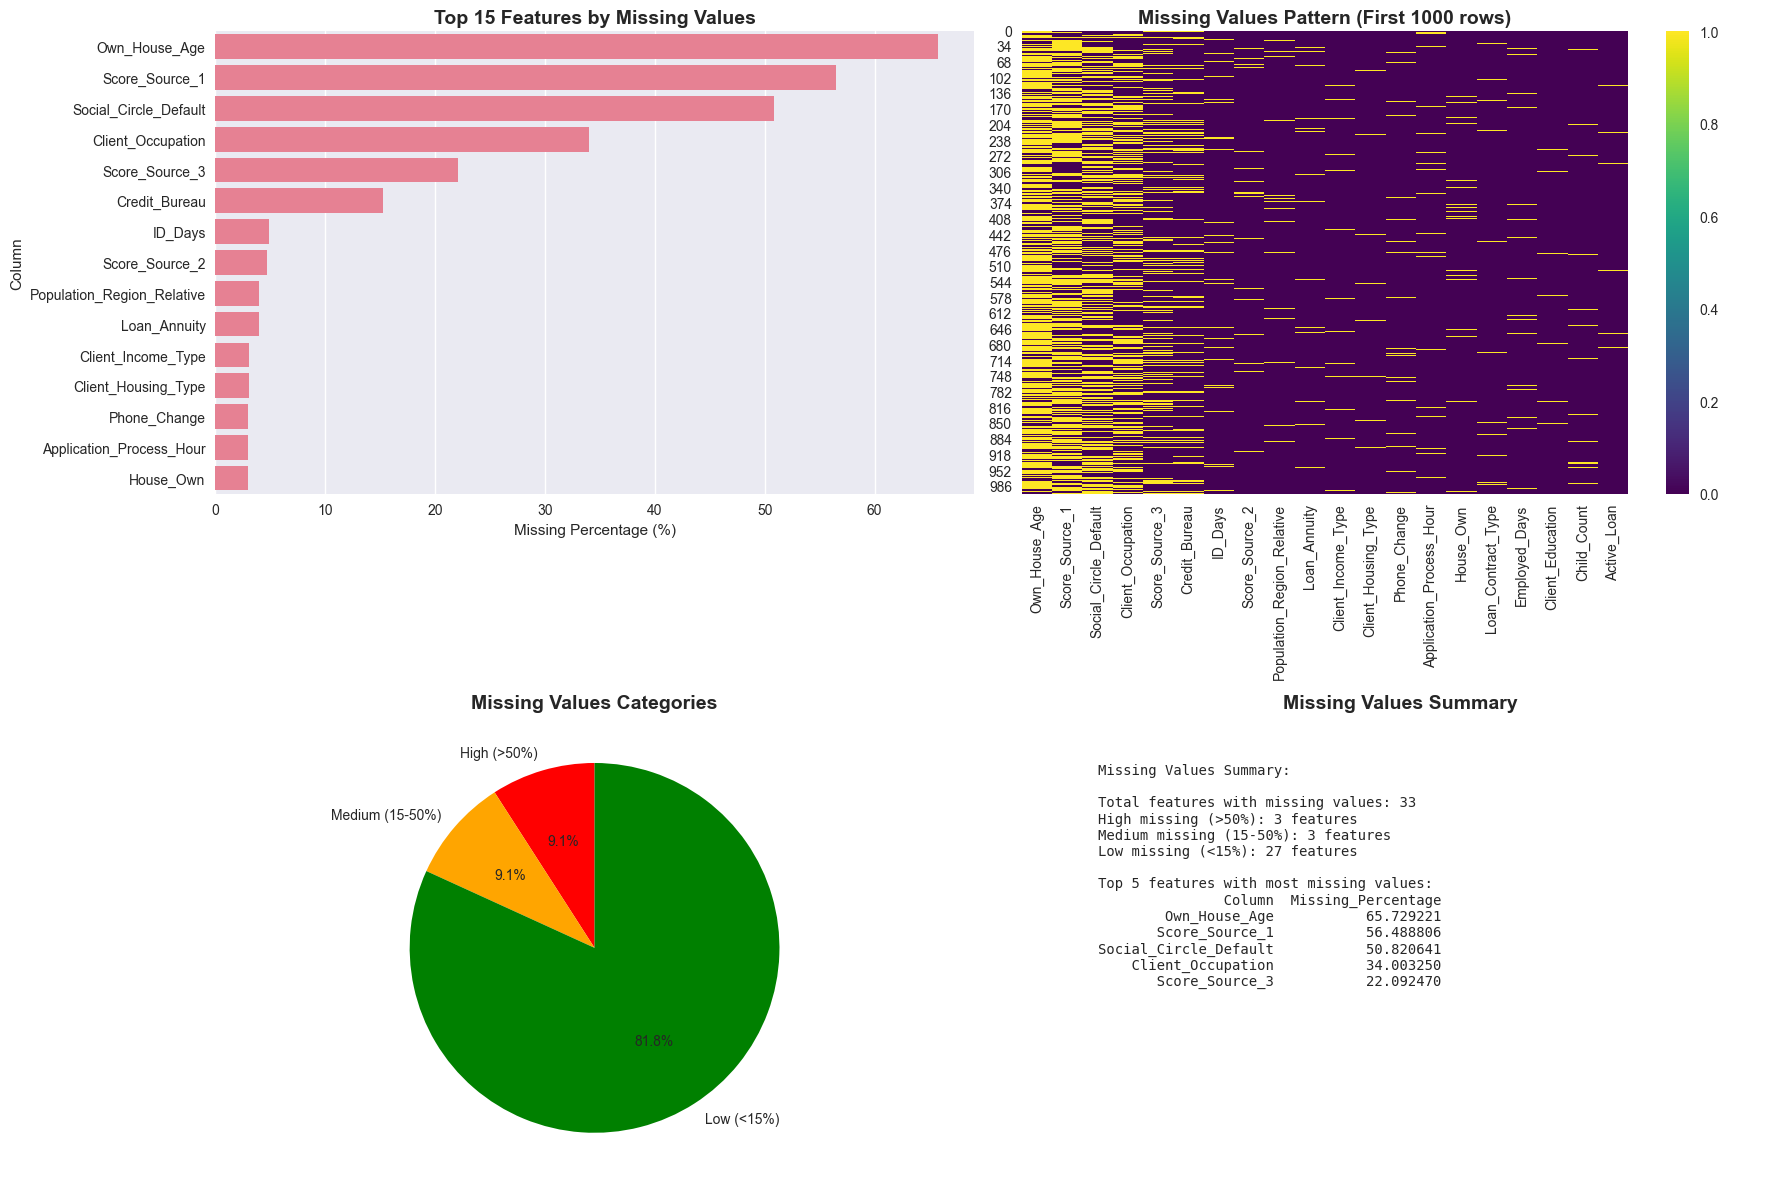

 MISSING VALUES SUMMARY:
   Total features with missing values: 33
   High missing (>50%): 3 features
   Medium missing (15-50%): 3 features
   Low missing (<15%): 27 features
 Found 18 numerical features


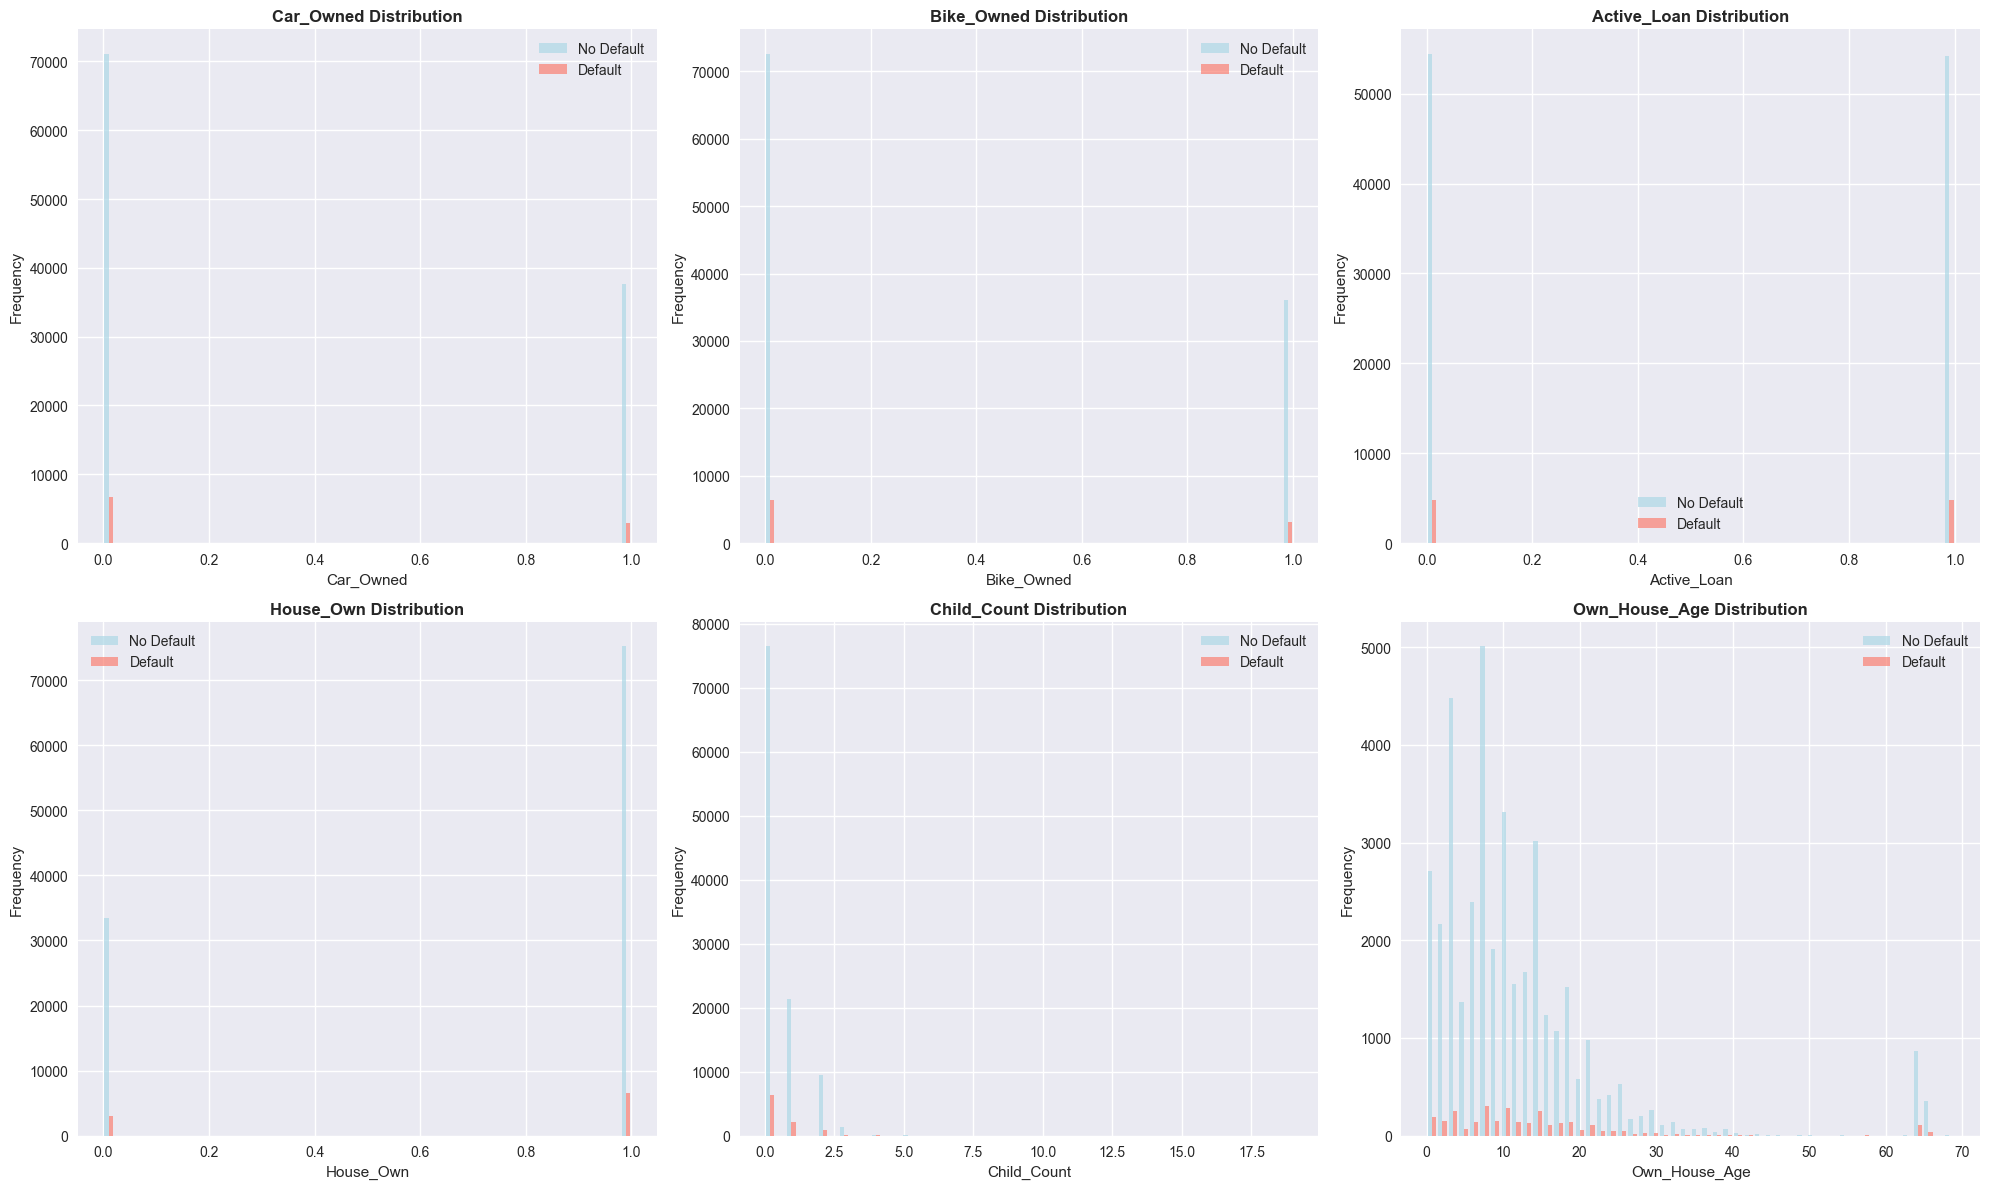


 NUMERICAL FEATURES SUMMARY:
           Car_Owned     Bike_Owned    Active_Loan      House_Own    Child_Count  Own_House_Age
count  118275.000000  118232.000000  118221.000000  118195.000000  118218.000000   41761.000000
mean        0.342854       0.332262       0.499175       0.692060       0.417779      12.157324
std         0.474665       0.471026       0.500001       0.461644       0.728802      12.056079
min         0.000000       0.000000       0.000000       0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000       0.000000       0.000000       5.000000
50%         0.000000       0.000000       0.000000       1.000000       0.000000       9.000000
75%         1.000000       1.000000       1.000000       1.000000       1.000000      15.000000
max         1.000000       1.000000       1.000000       1.000000      19.000000      69.000000
 Found 19 categorical features


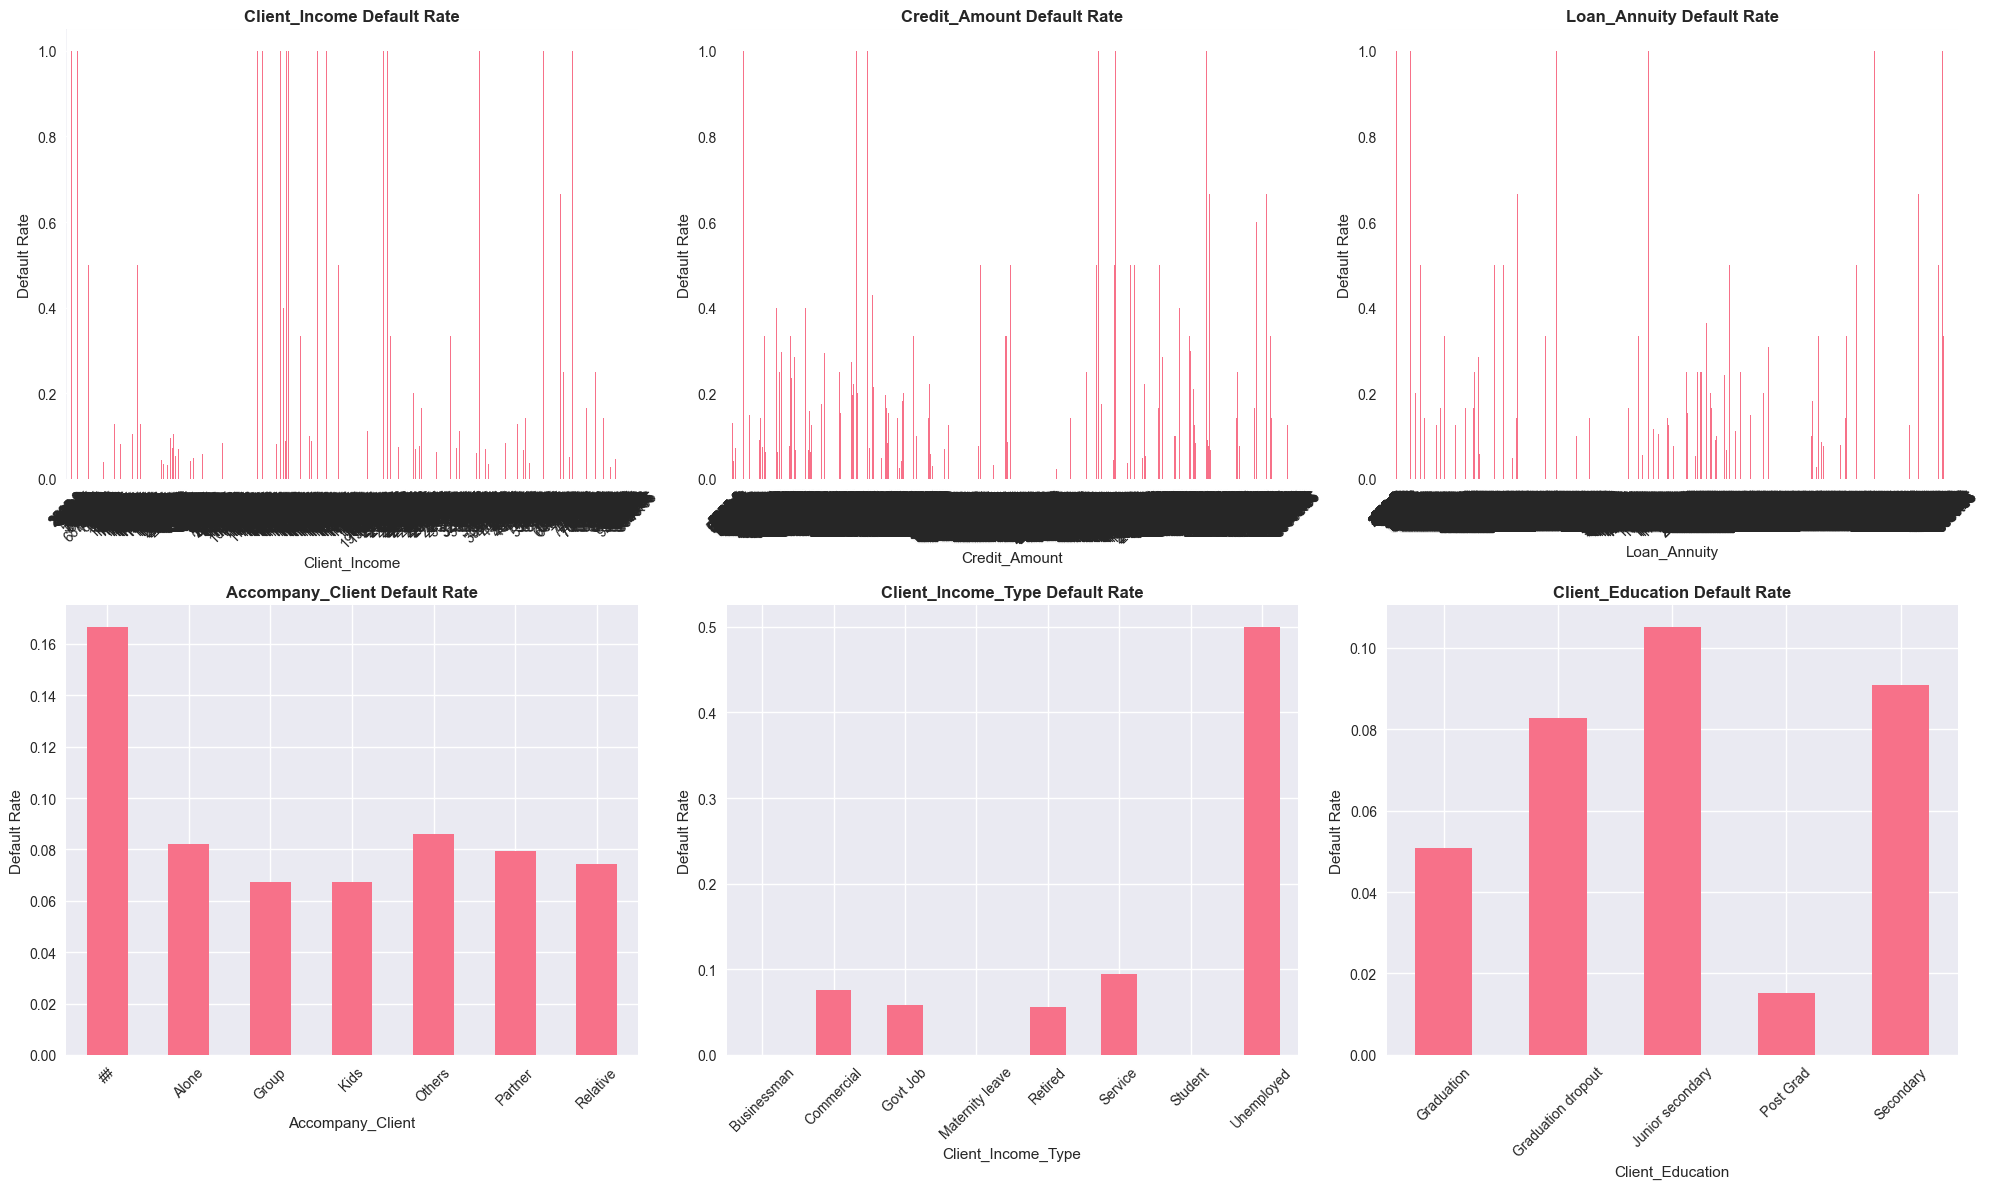


 CATEGORICAL FEATURES SUMMARY:
Client_Income: 1516 unique values

Credit_Amount: 6816 unique values

Loan_Annuity: 16680 unique values

Accompany_Client: 7 unique values
   Values: ['Alone' 'Relative' 'Others' 'Kids' nan 'Partner' '##' 'Group']

Client_Income_Type: 8 unique values
   Values: ['Commercial' 'Service' 'Retired' 'Govt Job' nan 'Student' 'Unemployed'
 'Maternity leave' 'Businessman']

Client_Education: 5 unique values
   Values: ['Secondary' 'Graduation' 'Graduation dropout' nan 'Junior secondary'
 'Post Grad']


 ENHANCED CORRELATION ANALYSIS


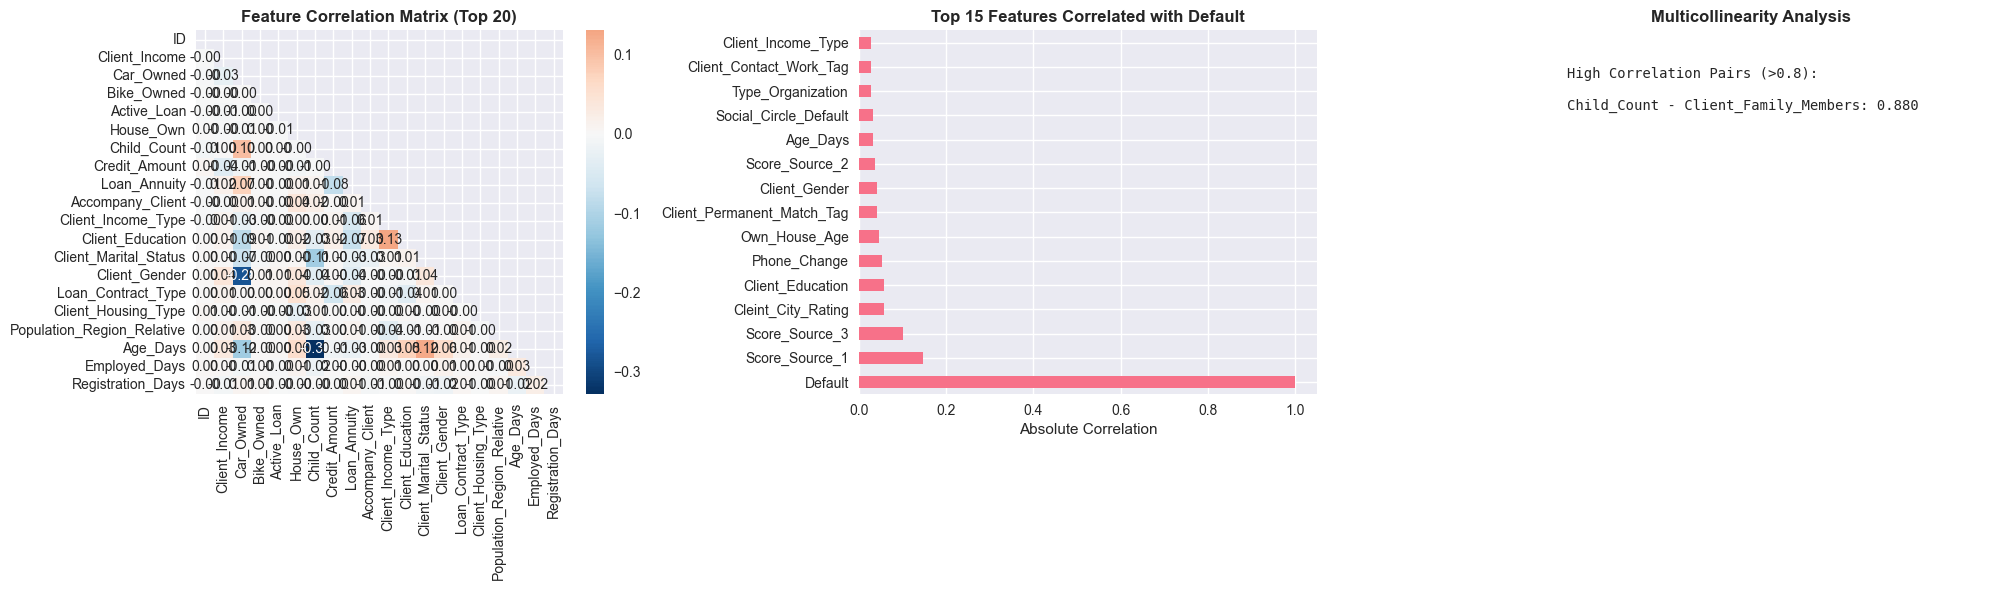


KEY CORRELATION INSIGHTS:
   Top 5 features correlated with Default:
   2. Score_Source_1: 0.147
   3. Score_Source_3: 0.102
   4. Cleint_City_Rating: 0.059
   5. Client_Education: 0.057

  High Multicollinearity Detected: 1 pairs


In [26]:

def analyze_target_variable(df, target_col='Default'):
    """Analyze target variable distribution"""
    if target_col not in df.columns:
        print(f" Target column '{target_col}' not found in dataset")
        return
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Count plot
    df[target_col].value_counts().plot(kind='bar', ax=axes[0,0], color=['lightblue', 'salmon'])
    axes[0,0].set_title('Default Distribution (Count)', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Default Status')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=0)
    
    # Percentage pie chart
    default_counts = df[target_col].value_counts()
    axes[0,1].pie(default_counts.values, labels=['No Default (0)', 'Default (1)'], 
                 autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
    axes[0,1].set_title('Default Distribution (Percentage)', fontsize=14, fontweight='bold')
    
    # Default rate visualization
    default_stats = pd.DataFrame({
        'Metric': ['Total Applications', 'Defaults', 'Non-Defaults'],
        'Value': [len(df), (df[target_col]==1).sum(), (df[target_col]==0).sum()]
    })
    axes[1,0].bar(default_stats['Metric'], default_stats['Value'], color=['skyblue', 'salmon', 'lightgreen'])
    axes[1,0].set_title('Application Statistics', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Count')
    plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=45)
    
    # Class imbalance visualization
    imbalance_ratio = (df[target_col]==0).sum() / (df[target_col]==1).sum()
    axes[1,1].bar(['Non-Default', 'Default'], [imbalance_ratio, 1], color=['lightblue', 'salmon'])
    axes[1,1].set_title(f'Class Imbalance Ratio: {imbalance_ratio:.1f}:1', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Ratio')
    
    plt.tight_layout()
    plt.show()
    
    print(f" KEY STATISTICS:")
    print(f"   Default Rate: {df[target_col].mean():.2%}")
    print(f"   Class Imbalance: {imbalance_ratio:.1f}:1 (Non-Default:Default)")
    print(f"   Total Applications: {len(df):,}")
    print(f"   Defaults: {(df[target_col]==1).sum():,}")
    print(f"   Non-Defaults: {(df[target_col]==0).sum():,}")

def analyze_missing_values(df):
    """Comprehensive missing values analysis"""
    # Calculate missing values
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_pct = (missing_data / len(df)) * 100
    
    # Create missing values dataframe
    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': missing_pct.values
    }).query('Missing_Count > 0').reset_index(drop=True)
    
    if len(missing_df) == 0:
        print(" No missing values found in the dataset!")
        return missing_df
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Missing values bar chart
    top_missing = missing_df.head(15)
    sns.barplot(data=top_missing, x='Missing_Percentage', y='Column', ax=axes[0,0])
    axes[0,0].set_title('Top 15 Features by Missing Values', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Missing Percentage (%)')
    
    # Missing values heatmap (sample)
    sample_cols = missing_df.head(20)['Column'].tolist()
    if sample_cols:
        missing_matrix = df[sample_cols].isnull().astype(int)
        sns.heatmap(missing_matrix.iloc[:1000], ax=axes[0,1], cbar=True, cmap='viridis')
        axes[0,1].set_title('Missing Values Pattern (First 1000 rows)', fontsize=14, fontweight='bold')
    
    # Missing values categories
    high_missing = missing_df[missing_df['Missing_Percentage'] > 50]
    medium_missing = missing_df[(missing_df['Missing_Percentage'] > 15) & (missing_df['Missing_Percentage'] <= 50)]
    low_missing = missing_df[missing_df['Missing_Percentage'] <= 15]
    
    categories = ['High (>50%)', 'Medium (15-50%)', 'Low (<15%)']
    counts = [len(high_missing), len(medium_missing), len(low_missing)]
    colors = ['red', 'orange', 'green']
    
    axes[1,0].pie(counts, labels=categories, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[1,0].set_title('Missing Values Categories', fontsize=14, fontweight='bold')
    
    # Missing values summary text
    summary_text = f"""Missing Values Summary:
    
Total features with missing values: {len(missing_df)}
High missing (>50%): {len(high_missing)} features
Medium missing (15-50%): {len(medium_missing)} features
Low missing (<15%): {len(low_missing)} features

Top 5 features with most missing values:
{missing_df.head(5)[['Column', 'Missing_Percentage']].to_string(index=False)}"""
    
    axes[1,1].text(0.1, 0.9, summary_text, transform=axes[1,1].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace')
    axes[1,1].set_title('Missing Values Summary', fontsize=14, fontweight='bold')
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(" MISSING VALUES SUMMARY:")
    print(f"   Total features with missing values: {len(missing_df)}")
    print(f"   High missing (>50%): {len(high_missing)} features")
    print(f"   Medium missing (15-50%): {len(medium_missing)} features")
    print(f"   Low missing (<15%): {len(low_missing)} features")
    
    return missing_df

def analyze_numerical_features(df, target_col='Default'):
    """Analyze numerical features"""
    # Get numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)
    
    # Remove ID columns
    numerical_cols = [col for col in numerical_cols if 'ID' not in col.upper()]
    
    print(f" Found {len(numerical_cols)} numerical features")
    
    if len(numerical_cols) == 0:
        print(" No numerical features found for analysis")
        return
    
    # Analyze top numerical features
    top_features = numerical_cols[:6]  # Analyze top 6
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(top_features):
        if i < 6:
            # Convert to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Distribution by default status
            no_default = df[df[target_col]==0][col].dropna()
            default = df[df[target_col]==1][col].dropna()
            
            axes[i].hist([no_default, default], bins=50, alpha=0.7, 
                        label=['No Default', 'Default'], color=['lightblue', 'salmon'])
            axes[i].set_title(f'{col} Distribution', fontweight='bold')
            axes[i].legend()
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print("\n NUMERICAL FEATURES SUMMARY:")
    summary_stats = df[top_features].describe()
    print(summary_stats)
    
    return numerical_cols

def analyze_categorical_features(df, target_col='Default'):
    """Analyze categorical features"""
    # Get categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Remove ID columns
    categorical_cols = [col for col in categorical_cols if 'ID' not in col.upper()]
    
    print(f" Found {len(categorical_cols)} categorical features")
    
    if len(categorical_cols) == 0:
        print(" No categorical features found for analysis")
        return
    
    # Analyze top categorical features
    top_features = categorical_cols[:6]  # Analyze top 6
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(top_features):
        if i < 6:
            # Calculate default rate by category
            default_rate = df.groupby(col)[target_col].mean()
            
            # Plot default rate
            default_rate.plot(kind='bar', ax=axes[i])
            axes[i].set_title(f'{col} Default Rate', fontweight='bold')
            axes[i].set_ylabel('Default Rate')
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Show unique values for categorical features
    print("\n CATEGORICAL FEATURES SUMMARY:")
    for col in top_features:
        unique_count = df[col].nunique()
        print(f"{col}: {unique_count} unique values")
        if unique_count <= 10:
            print(f"   Values: {df[col].unique()}")
        print()
    
    return categorical_cols

# Run EDA if data is loaded
if df is not None:
    print("\n" + "="*60)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*60)
    
    # Analyze target variable
    analyze_target_variable(df)
    
    # Analyze missing values
    missing_df = analyze_missing_values(df)
    
    # Analyze numerical features
    numerical_cols = analyze_numerical_features(df)
    
    # Analyze categorical features
    categorical_cols = analyze_categorical_features(df)
    
    # Enhanced Correlation Analysis
    print("\n" + "="*60)
    print(" ENHANCED CORRELATION ANALYSIS")
    print("="*60)
    
    # Run enhanced correlation analysis
    target_corr, high_corr_pairs = enhanced_correlation_analysis(df)
    
    print(f"\nKEY CORRELATION INSIGHTS:")
    print(f"   Top 5 features correlated with Default:")
    for i, (feature, corr) in enumerate(target_corr.head(5).items(), 1):
        if feature != 'Default':
            print(f"   {i}. {feature}: {corr:.3f}")
    
    if high_corr_pairs:
        print(f"\n  High Multicollinearity Detected: {len(high_corr_pairs)} pairs")
    else:
        print(f"\n No significant multicollinearity issues")


In [27]:
def handle_missing_values_advanced(df):
    """Advanced missing value treatment"""
    df_clean = df.copy()
    
    # Define thresholds
    high_missing_threshold = 0.5  # 50%
    medium_missing_threshold = 0.15  # 15%
    
    missing_summary = []
    
    for col in df_clean.columns:
        if col in ['ID', 'Default']:
            continue
            
        missing_count = df_clean[col].isnull().sum()
        missing_pct = missing_count / len(df_clean)
        
        if missing_count > 0:
            strategy = "None"
            
            if missing_pct > high_missing_threshold:
                # High missing: Create indicator + impute
                df_clean[f'{col}_missing'] = df_clean[col].isnull().astype(int)
                
                if df_clean[col].dtype in ['int64', 'float64']:
                    fill_value = df_clean[col].median()
                    df_clean[col].fillna(fill_value, inplace=True)
                    strategy = f"Indicator + Median ({fill_value:.2f})"
                else:
                    fill_value = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
                    df_clean[col].fillna(fill_value, inplace=True)
                    strategy = f"Indicator + Mode ({fill_value})"
                    
            elif missing_pct > medium_missing_threshold:
                # Medium missing: Smart imputation
                if df_clean[col].dtype in ['int64', 'float64']:
                    fill_value = df_clean[col].median()
                    df_clean[col].fillna(fill_value, inplace=True)
                    strategy = f"Median ({fill_value:.2f})"
                else:
                    fill_value = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
                    df_clean[col].fillna(fill_value, inplace=True)
                    strategy = f"Mode ({fill_value})"
                    
            else:
                # Low missing: KNN imputation for numerical, mode for categorical
                if df_clean[col].dtype in ['int64', 'float64']:
                    try:
                        # Use median as fallback for KNN
                        fill_value = df_clean[col].median()
                        df_clean[col].fillna(fill_value, inplace=True)
                        strategy = f"Median ({fill_value:.2f})"
                    except:
                        fill_value = df_clean[col].median()
                        df_clean[col].fillna(fill_value, inplace=True)
                        strategy = f"Median Fallback ({fill_value:.2f})"
                else:
                    fill_value = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
                    df_clean[col].fillna(fill_value, inplace=True)
                    strategy = f"Mode ({fill_value})"
            
            missing_summary.append({
                'Column': col,
                'Missing_Count': missing_count,
                'Missing_Percentage': missing_pct * 100,
                'Strategy': strategy
            })
    
    return df_clean, pd.DataFrame(missing_summary)

def create_advanced_features(df):
    """Create advanced features based on domain knowledge"""
    df_new = df.copy()
    feature_log = []
    
    # Convert common columns to numeric
    numeric_cols = ['Age_Days', 'Employed_Days', 'Credit_Amount', 'Client_Income', 
                   'Loan_Annuity', 'Client_Family_Members']
    
    for col in numeric_cols:
        if col in df_new.columns:
            df_new[col] = pd.to_numeric(df_new[col], errors='coerce')
    
    # 1. Age and Employment Features
    if 'Age_Days' in df_new.columns:
        df_new['Age_Years'] = abs(df_new['Age_Days']) / 365.25
        feature_log.append("Age_Years: Converted from days to years")
        
        # Age categories
        df_new['Age_Category'] = pd.cut(df_new['Age_Years'], 
                                       bins=[0, 25, 35, 45, 55, 100], 
                                       labels=['Young', 'Adult', 'Middle', 'Senior', 'Elder'])
        feature_log.append("Age_Category: Categorical age groups")
    
    if 'Employed_Days' in df_new.columns:
        df_new['Is_Employed'] = (df_new['Employed_Days'] > 0).astype(int)
        df_new['Employment_Years'] = abs(df_new['Employed_Days']) / 365.25
        feature_log.append("Employment features: Is_Employed, Employment_Years")
    
    # 2. Financial Ratios
    if 'Credit_Amount' in df_new.columns and 'Client_Income' in df_new.columns:
        # Debt-to-Income Ratio
        df_new['Debt_to_Income'] = df_new['Credit_Amount'] / (df_new['Client_Income'] + 1)
        feature_log.append("Debt_to_Income: Credit amount / Income ratio")
    
    if 'Loan_Annuity' in df_new.columns and 'Client_Income' in df_new.columns:
        df_new['Annuity_to_Income'] = df_new['Loan_Annuity'] / (df_new['Client_Income'] + 1)
        feature_log.append("Annuity_to_Income: Payment burden ratio")
    
    # 3. Asset Features
    asset_columns = ['Car_Owned', 'Bike_Owned', 'House_Own']
    available_assets = [col for col in asset_columns if col in df_new.columns]
    
    if available_assets:
        # Convert to numeric
        for col in available_assets:
            df_new[col] = pd.to_numeric(df_new[col], errors='coerce').fillna(0)
        
        df_new['Total_Assets'] = df_new[available_assets].sum(axis=1)
        feature_log.append("Total_Assets: Sum of owned assets")
    
    # 4. Family Features
    if 'Client_Family_Members' in df_new.columns and 'Client_Income' in df_new.columns:
        df_new['Income_per_Family_Member'] = df_new['Client_Income'] / (df_new['Client_Family_Members'] + 1)
        feature_log.append("Income_per_Family_Member: Family financial pressure")
    
    return df_new, feature_log

def detect_and_treat_outliers(df, columns, method='iqr'):
    """Detect and treat outliers using IQR method"""
    df_clean = df.copy()
    outlier_summary = []
    
    for col in columns:
        if col in df_clean.columns and df_clean[col].dtype in ['int64', 'float64']:
            # Convert to numeric first
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            
            if IQR > 0:
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers_mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
                outliers_count = outliers_mask.sum()
                
                if outliers_count > 0:
                    # Clip outliers
                    df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
                    
                    outlier_summary.append({
                        'Column': col,
                        'Outliers_Count': outliers_count,
                        'Outliers_Percentage': (outliers_count / len(df_clean)) * 100,
                        'Lower_Bound': lower_bound,
                        'Upper_Bound': upper_bound
                    })
    
    return df_clean, pd.DataFrame(outlier_summary)

# Apply preprocessing if data is loaded
if df is not None:
    print("\n" + "="*60)
    print(" ADVANCED DATA PREPROCESSING")
    print("="*60)
    
    # Handle missing values
    df_processed, missing_treatment_summary = handle_missing_values_advanced(df)
    
    print(" MISSING VALUE TREATMENT SUMMARY:")
    if len(missing_treatment_summary) > 0:
        print(missing_treatment_summary.sort_values('Missing_Percentage', ascending=False))
    else:
        print(" No missing values found!")
    
    print(f"\n Missing values before: {df.isnull().sum().sum():,}")
    print(f" Missing values after: {df_processed.isnull().sum().sum():,}")
    
    # Feature engineering
    df_features, feature_creation_log = create_advanced_features(df_processed)
    
    print("\n FEATURE ENGINEERING SUMMARY:")
    for log_entry in feature_creation_log:
        print(f" {log_entry}")
    
    print(f"\n Feature Engineering Results:")
    print(f"   Original features: {df_processed.shape[1]}")
    print(f"   New features: {df_features.shape[1]}")
    print(f"   Features added: {df_features.shape[1] - df_processed.shape[1]}")
    
    # Outlier treatment
    numerical_features = df_features.select_dtypes(include=[np.number]).columns.tolist()
    numerical_features = [col for col in numerical_features if col not in ['Default', 'ID']]
    
    df_final, outlier_summary = detect_and_treat_outliers(df_features, numerical_features)
    
    print("\n OUTLIER TREATMENT SUMMARY:")
    if len(outlier_summary) > 0:
        print(outlier_summary)
    else:
        print("✅ No outliers detected or treated!")


 ADVANCED DATA PREPROCESSING
 MISSING VALUE TREATMENT SUMMARY:
                        Column  Missing_Count  Missing_Percentage                       Strategy
20               Own_House_Age          80095           65.729221      Indicator + Median (9.00)
27              Score_Source_1          68835           56.488806      Indicator + Median (0.50)
30       Social_Circle_Default          61928           50.820641      Indicator + Median (0.09)
21           Client_Occupation          41435           34.003250                Mode (Laborers)
29              Score_Source_3          26921           22.092470             Mode (0.746300213)
32               Credit_Bureau          18540           15.214680                  Median (1.00)
19                     ID_Days           5968            4.897584                    Mode (4053)
28              Score_Source_2           5686            4.666163                  Median (0.56)
15  Population_Region_Relative           4857            3.9858

In [28]:
def prepare_final_dataset(df, target_col='Default'):
    """Prepare final dataset for modeling"""
    
    # Check if target column exists
    if target_col not in df.columns:
        print(f" Target column '{target_col}' not found in dataset")
        return None, None, None
    
    # Separate features and target
    X = df.drop([target_col], axis=1, errors='ignore')
    
    # Remove ID columns
    id_cols = [col for col in X.columns if 'ID' in col.upper()]
    X = X.drop(id_cols, axis=1, errors='ignore')
    
    y = df[target_col]
    
    # Encode categorical variables
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    label_encoders = {}
    
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    # Handle any remaining NaN values
    X = X.fillna(X.median())
    
    return X, y, label_encoders

def train_and_evaluate_models(X, y):
    """Train and evaluate multiple models"""
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(
            class_weight='balanced', 
            random_state=42,
            max_iter=1000
        ),
        'Random Forest': RandomForestClassifier(
            class_weight='balanced',
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': XGBClassifier(
            max_depth=6,
            learning_rate=0.1,
            n_estimators=100,
            subsample=0.8,
            scale_pos_weight=1.5,
            random_state=42,
            n_jobs=-1
        ),
        'Extra Trees': ExtraTreesClassifier(
            class_weight='balanced',
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
    }
    
    # Cross-validation setup
    cv_folds = 5
    cv_scoring = ['roc_auc', 'precision', 'recall', 'f1']
    
    # Store results
    cv_results = {}
    
    print(" COMPREHENSIVE MODEL TRAINING:")
    print("=" * 50)
    
    for name, model in models.items():
        print(f"\n Training {name}...")
        
        # Perform cross-validation
        cv_scores = {}
        
        for scoring in cv_scoring:
            try:
                scores = cross_val_score(
                    model, X, y, 
                    cv=cv_folds, scoring=scoring, n_jobs=-1
                )
                cv_scores[scoring] = {
                    'mean': scores.mean(),
                    'std': scores.std(),
                    'scores': scores
                }
            except Exception as e:
                print(f"    Error with {scoring}: {e}")
                cv_scores[scoring] = {
                    'mean': 0.0,
                    'std': 0.0,
                    'scores': np.array([0.0])
                }
        
        cv_results[name] = cv_scores
        
        # Print results
        print(f"   AUC: {cv_scores['roc_auc']['mean']:.4f} (+/- {cv_scores['roc_auc']['std']*2:.4f})")
        print(f"   Precision: {cv_scores['precision']['mean']:.4f} (+/- {cv_scores['precision']['std']*2:.4f})")
        print(f"   Recall: {cv_scores['recall']['mean']:.4f} (+/- {cv_scores['recall']['std']*2:.4f})")
        print(f"   F1: {cv_scores['f1']['mean']:.4f} (+/- {cv_scores['f1']['std']*2:.4f})")
    
    # Create results summary
    results_summary = []
    for model_name, scores in cv_results.items():
        results_summary.append({
            'Model': model_name,
            'AUC_Mean': scores['roc_auc']['mean'],
            'AUC_Std': scores['roc_auc']['std'],
            'Precision_Mean': scores['precision']['mean'],
            'Recall_Mean': scores['recall']['mean'],
            'F1_Mean': scores['f1']['mean']
        })
    
    results_df = pd.DataFrame(results_summary).sort_values('AUC_Mean', ascending=False)
    
    print("\n MODEL COMPARISON SUMMARY:")
    print(results_df.round(4))
    
    return models, cv_results, results_df

def visualize_model_comparison(cv_results, results_df):
    """Visualize model comparison results"""
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. AUC Score Comparison
    model_names = list(cv_results.keys())
    auc_scores = [cv_results[name]['roc_auc']['mean'] for name in model_names]
    auc_stds = [cv_results[name]['roc_auc']['std'] for name in model_names]
    
    axes[0,0].bar(model_names, auc_scores, yerr=auc_stds, capsize=5, color='skyblue')
    axes[0,0].set_title('Cross-Validation AUC Scores', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('AUC Score')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Precision-Recall Comparison
    precision_scores = [cv_results[name]['precision']['mean'] for name in model_names]
    recall_scores = [cv_results[name]['recall']['mean'] for name in model_names]
    
    axes[0,1].scatter(recall_scores, precision_scores, s=100, alpha=0.7, color='orange')
    for i, name in enumerate(model_names):
        axes[0,1].annotate(name, (recall_scores[i], precision_scores[i]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=9)
    axes[0,1].set_xlabel('Recall')
    axes[0,1].set_ylabel('Precision')
    axes[0,1].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. F1 Score Comparison
    f1_scores = [cv_results[name]['f1']['mean'] for name in model_names]
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
    bars = axes[1,0].bar(model_names, f1_scores, color=colors)
    axes[1,0].set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, score in zip(bars, f1_scores):
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{score:.3f}', ha='center', va='bottom')
    
    # 4. Performance Heatmap
    metrics_matrix = []
    for name in model_names:
        row = [
            cv_results[name]['roc_auc']['mean'],
            cv_results[name]['precision']['mean'],
            cv_results[name]['recall']['mean'],
            cv_results[name]['f1']['mean']
        ]
        metrics_matrix.append(row)
    
    metrics_df = pd.DataFrame(metrics_matrix, 
                             index=model_names, 
                             columns=['AUC', 'Precision', 'Recall', 'F1'])
    
    sns.heatmap(metrics_df, annot=True, cmap='RdYlBu_r', center=0.5, 
                fmt='.3f', square=True, linewidths=0.5, ax=axes[1,1])
    axes[1,1].set_title('Model Performance Heatmap', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def train_best_model(models, results_df, X, y):
    """Train the best model and make predictions"""
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"🔄 TRAIN-TEST SPLIT:")
    print(f"   Training set: {X_train.shape}")
    print(f"   Test set: {X_test.shape}")
    print(f"   Training target distribution: {np.bincount(y_train)}")
    print(f"   Test target distribution: {np.bincount(y_test)}")
    
    # Handle class imbalance with SMOTE
    print("\n🔄 APPLYING SMOTE FOR CLASS IMBALANCE:")
    smote = SMOTE(sampling_strategy=0.5, random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"   Original training: {np.bincount(y_train)}")
    print(f"   Balanced training: {np.bincount(y_train_balanced)}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)
    
    # Select best model
    best_model_name = results_df.iloc[0]['Model']
    best_model = models[best_model_name]
    
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   Cross-Validation AUC: {results_df.iloc[0]['AUC_Mean']:.4f}")
    
    # Train best model
    best_model.fit(X_train_scaled, y_train_balanced)
    
    # Make predictions
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate test metrics
    test_metrics = {
        'AUC': roc_auc_score(y_test, y_pred_proba),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }
    
    print(f"\n TEST SET PERFORMANCE:")
    for metric, value in test_metrics.items():
        print(f"   {metric}: {value:.4f}")
    
    # Classification report
    print(f"\n DETAILED CLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred))
    
    return best_model, scaler, X_test, y_test, y_pred, y_pred_proba, test_metrics

def evaluate_model_performance(y_test, y_pred, y_pred_proba, best_model, X_train):
    """Comprehensive model evaluation"""
    
    # Calculate curves
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
    
    # Create evaluation plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. ROC Curve
    test_auc = roc_auc_score(y_test, y_pred_proba)
    axes[0,0].plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {test_auc:.4f})')
    axes[0,0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[0,0].set_xlabel('False Positive Rate')
    axes[0,0].set_ylabel('True Positive Rate')
    axes[0,0].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Precision-Recall Curve
    pr_auc = average_precision_score(y_test, y_pred_proba)
    axes[0,1].plot(recall_curve, precision_curve, linewidth=3, label=f'PR Curve (AUC = {pr_auc:.4f})')
    axes[0,1].axhline(y=y_test.mean(), color='k', linestyle='--', alpha=0.5, label='Random')
    axes[0,1].set_xlabel('Recall')
    axes[0,1].set_ylabel('Precision')
    axes[0,1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,2])
    axes[0,2].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0,2].set_ylabel('Actual')
    axes[0,2].set_xlabel('Predicted')
    
    # 4. Prediction Distribution
    axes[1,0].hist([y_pred_proba[y_test==0], y_pred_proba[y_test==1]], 
                   bins=50, alpha=0.7, label=['No Default', 'Default'], color=['lightblue', 'salmon'])
    axes[1,0].set_xlabel('Predicted Probability')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Threshold Analysis
    thresholds = np.linspace(0, 1, 100)
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba >= thresh).astype(int)
        if len(np.unique(y_pred_thresh)) > 1:
            precision_scores.append(precision_score(y_test, y_pred_thresh))
            recall_scores.append(recall_score(y_test, y_pred_thresh))
            f1_scores.append(f1_score(y_test, y_pred_thresh))
        else:
            precision_scores.append(0)
            recall_scores.append(0)
            f1_scores.append(0)
    
    axes[1,1].plot(thresholds, precision_scores, label='Precision', linewidth=2)
    axes[1,1].plot(thresholds, recall_scores, label='Recall', linewidth=2)
    axes[1,1].plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
    axes[1,1].set_xlabel('Threshold')
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_title('Threshold Analysis', fontsize=14, fontweight='bold')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Feature Importance (if available)
    if hasattr(best_model, 'feature_importances_'):
        feature_imp = pd.DataFrame({
            'feature': X_train.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False).head(15)
        
        sns.barplot(data=feature_imp, x='importance', y='feature', ax=axes[1,2])
        axes[1,2].set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
        axes[1,2].set_xlabel('Importance Score')
    else:
        axes[1,2].text(0.5, 0.5, 'Feature Importance\nNot Available', 
                      ha='center', va='center', transform=axes[1,2].transAxes)
        axes[1,2].set_title('Feature Importance', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    
def analyze_business_impact(y_test, y_pred_proba, thresholds=[0.3, 0.5, 0.7]):
    """Analyze business impact at different thresholds"""
    
    results = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba >= thresh).astype(int)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
        
        # Business metrics
        total_applications = len(y_test)
        approved_applications = (y_pred_thresh == 0).sum()
        rejected_applications = (y_pred_thresh == 1).sum()
        
        # Financial assumptions
        avg_loan_amount = 50000
        default_loss_rate = 0.6
        profit_margin = 0.05
        
        # Calculate financial impact
        lost_revenue = fp * avg_loan_amount * profit_margin
        prevented_losses = tp * avg_loan_amount * default_loss_rate
        actual_losses = fn * avg_loan_amount * default_loss_rate
        
        net_benefit = prevented_losses - lost_revenue
        
        results.append({
            'Threshold': thresh,
            'Approved_Applications': approved_applications,
            'Rejected_Applications': rejected_applications,
            'Approval_Rate': approved_applications / total_applications * 100,
            'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'Lost_Revenue': lost_revenue,
            'Prevented_Losses': prevented_losses,
            'Net_Benefit': net_benefit
        })
    
    impact_df = pd.DataFrame(results)
    
    print(" BUSINESS IMPACT ANALYSIS:")
    print(impact_df.round(2))
    
    # Visualize business impact
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Net benefit by threshold
    axes[0].plot(impact_df['Threshold'], impact_df['Net_Benefit'], 
                marker='o', linewidth=2, markersize=8, color='green')
    axes[0].set_xlabel('Risk Threshold')
    axes[0].set_ylabel('Net Benefit ($)')
    axes[0].set_title('Net Financial Benefit by Threshold', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Approval rate vs precision
    axes[1].scatter(impact_df['Approval_Rate'], impact_df['Precision'], 
                   s=100, c=impact_df['Threshold'], cmap='viridis')
    for i, row in impact_df.iterrows():
        axes[1].annotate(f'{row["Threshold"]}', 
                        (row['Approval_Rate'], row['Precision']),
                        xytext=(5, 5), textcoords='offset points')
    axes[1].set_xlabel('Approval Rate (%)')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Approval Rate vs Precision Trade-off', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return impact_df

def save_model_artifacts(best_model, scaler, label_encoders, X_train, test_metrics):
    """Save model artifacts for deployment"""
    
    # Create model artifacts dictionary
    model_artifacts = {
        'model': best_model,
        'scaler': scaler,
        'label_encoders': label_encoders,
        'feature_names': list(X_train.columns),
        'model_metadata': {
            'model_type': type(best_model).__name__,
            'training_date': datetime.now().isoformat(),
            'test_auc': test_metrics['AUC'],
            'test_accuracy': test_metrics['Accuracy'],
            'feature_count': len(X_train.columns),
            'training_samples': len(X_train)
        }
    }
    
    # Save artifacts
    try:
        with open('model_artifacts.pkl', 'wb') as f:
            pickle.dump(model_artifacts, f)
        
        # Save individual components
        joblib.dump(best_model, 'best_loan_model.joblib')
        joblib.dump(scaler, 'feature_scaler.joblib')
        
        print(" Model artifacts saved successfully:")
        print("   - model_artifacts.pkl (complete package)")
        print("   - best_loan_model.joblib (model only)")
        print("   - feature_scaler.joblib (scaler only)")
        
        return True
    except Exception as e:
        print(f" Error saving model artifacts: {e}")
        return False

def create_prediction_function():
    """Create a simple prediction function for new data"""
    
    prediction_code = '''
def predict_loan_default(loan_data_dict):
    """
    Predict loan default for new applications
    
    Parameters:
    loan_data_dict: Dictionary containing loan application data
    
    Returns:
    Dictionary with prediction results
    """
    import pandas as pd
    import numpy as np
    import joblib
    import pickle
    
    try:
        # Load model artifacts
        with open('model_artifacts.pkl', 'rb') as f:
            artifacts = pickle.load(f)
        
        model = artifacts['model']
        scaler = artifacts['scaler']
        label_encoders = artifacts['label_encoders']
        feature_names = artifacts['feature_names']
        
        # Convert input to DataFrame
        df = pd.DataFrame([loan_data_dict])
        
        # Apply same preprocessing steps
        # (Add your feature engineering here)
        
        # Handle missing values
        df = df.fillna(df.median())
        
        # Encode categorical variables
        for col, encoder in label_encoders.items():
            if col in df.columns:
                df[col] = encoder.transform(df[col].astype(str))
        
        # Ensure all required features are present
        missing_features = set(feature_names) - set(df.columns)
        if missing_features:
            for feature in missing_features:
                df[feature] = 0  # Default value
        
        # Reorder columns to match training data
        df = df[feature_names]
        
        # Scale features
        df_scaled = scaler.transform(df)
        
        # Make prediction
        prediction = model.predict(df_scaled)[0]
        probability = model.predict_proba(df_scaled)[0][1]
        
        # Classify risk level
        if probability >= 0.7:
            risk_level = "High Risk"
        elif probability >= 0.3:
            risk_level = "Medium Risk"
        else:
            risk_level = "Low Risk"
        
        return {
            'prediction': int(prediction),
            'probability': float(probability),
            'risk_level': risk_level,
            'recommendation': 'Reject' if prediction == 1 else 'Approve'
        }
        
    except Exception as e:
        return {
            'error': str(e),
            'prediction': None,
            'probability': None,
            'risk_level': None,
            'recommendation': 'Manual Review Required'
        }

# Example usage:
# loan_application = {
#     'Client_Income': 150000,
#     'Credit_Amount': 500000,
#     'Loan_Annuity': 25000,
#     'Age_Days': -15000,
#     'Employed_Days': -2000,
#     'Car_Owned': 1,
#     'House_Own': 1,
#     # ... add other required features
# }
# 
# result = predict_loan_default(loan_application)
# print(result)
    '''
    
    return prediction_code


In [ ]:
def analyze_business_impact(y_test, y_pred_proba, thresholds=[0.3, 0.5, 0.7]):
    """Analyze business impact at different thresholds"""
    
    results = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba >= thresh).astype(int)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
        
        # Business metrics
        total_applications = len(y_test)
        approved_applications = (y_pred_thresh == 0).sum()
        rejected_applications = (y_pred_thresh == 1).sum()
        
        # Financial assumptions
        avg_loan_amount = 50000
        default_loss_rate = 0.6
        profit_margin = 0.05
        
        # Calculate financial impact
        lost_revenue = fp * avg_loan_amount * profit_margin
        prevented_losses = tp * avg_loan_amount * default_loss_rate
        actual_losses = fn * avg_loan_amount * default_loss_rate
        
        net_benefit = prevented_losses - lost_revenue
        
        results.append({
            'Threshold': thresh,
            'Approved_Applications': approved_applications,
            'Rejected_Applications': rejected_applications,
            'Approval_Rate': approved_applications / total_applications * 100,
            'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'Lost_Revenue': lost_revenue,
            'Prevented_Losses': prevented_losses,
            'Net_Benefit': net_benefit
        })
    
    impact_df = pd.DataFrame(results)
    
    print("BUSINESS IMPACT ANALYSIS:")
    print(impact_df.round(2))
    
    # Visualize business impact
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Net benefit by threshold
    axes[0].plot(impact_df['Threshold'], impact_df['Net_Benefit'], 
                marker='o', linewidth=2, markersize=8, color='green')
    axes[0].set_xlabel('Risk Threshold')
    axes[0].set_ylabel('Net Benefit ($)')
    axes[0].set_title('Net Financial Benefit by Threshold', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Approval rate vs precision
    axes[1].scatter(impact_df['Approval_Rate'], impact_df['Precision'], 
                   s=100, c=impact_df['Threshold'], cmap='viridis')
    for i, row in impact_df.iterrows():
        axes[1].annotate(f'{row["Threshold"]}', 
                        (row['Approval_Rate'], row['Precision']),
                        xytext=(5, 5), textcoords='offset points')
    axes[1].set_xlabel('Approval Rate (%)')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Approval Rate vs Precision Trade-off', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return impact_df

def save_model_artifacts(best_model, scaler, label_encoders, X_train, test_metrics):
    """Save model artifacts for deployment"""
    
    # Create model artifacts dictionary
    model_artifacts = {
        'model': best_model,
        'scaler': scaler,
        'label_encoders': label_encoders,
        'feature_names': list(X_train.columns),
        'model_metadata': {
            'model_type': type(best_model).__name__,
            'training_date': datetime.now().isoformat(),
            'test_auc': test_metrics['AUC'],
            'test_accuracy': test_metrics['Accuracy'],
            'feature_count': len(X_train.columns),
            'training_samples': len(X_train)
        }
    }
    
    # Save artifacts
    try:
        with open('model_artifacts.pkl', 'wb') as f:
            pickle.dump(model_artifacts, f)
        
        # Save individual components
        joblib.dump(best_model, 'best_loan_model.joblib')
        joblib.dump(scaler, 'feature_scaler.joblib')
        
        print(" Model artifacts saved successfully:")
        print("   - model_artifacts.pkl (complete package)")
        print("   - best_loan_model.joblib (model only)")
        print("   - feature_scaler.joblib (scaler only)")
        
        return True
    except Exception as e:
        print(f"Error saving model artifacts: {e}")
        return False

def create_prediction_function():
    """Create a simple prediction function for new data"""
    
    prediction_code = '''
def predict_loan_default(loan_data_dict):
    """
    Predict loan default for new applications
    
    Parameters:
    loan_data_dict: Dictionary containing loan application data
    
    Returns:
    Dictionary with prediction results
    """
    import pandas as pd
    import numpy as np
    import joblib
    import pickle
    
    try:
        # Load model artifacts
        with open('model_artifacts.pkl', 'rb') as f:
            artifacts = pickle.load(f)
        
        model = artifacts['model']
        scaler = artifacts['scaler']
        label_encoders = artifacts['label_encoders']
        feature_names = artifacts['feature_names']
        
        # Convert input to DataFrame
        df = pd.DataFrame([loan_data_dict])
        
        # Apply same preprocessing steps
        # (Add your feature engineering here)
        
        # Handle missing values
        df = df.fillna(df.median())
        
        # Encode categorical variables
        for col, encoder in label_encoders.items():
            if col in df.columns:
                df[col] = encoder.transform(df[col].astype(str))
        
        # Ensure all required features are present
        missing_features = set(feature_names) - set(df.columns)
        if missing_features:
            for feature in missing_features:
                df[feature] = 0  # Default value
        
        # Reorder columns to match training data
        df = df[feature_names]
        
        # Scale features
        df_scaled = scaler.transform(df)
        
        # Make prediction
        prediction = model.predict(df_scaled)[0]
        probability = model.predict_proba(df_scaled)[0][1]
        
        # Classify risk level
        if probability >= 0.7:
            risk_level = "High Risk"
        elif probability >= 0.3:
            risk_level = "Medium Risk"
        else:
            risk_level = "Low Risk"
        
        return {
            'prediction': int(prediction),
            'probability': float(probability),
            'risk_level': risk_level,
            'recommendation': 'Reject' if prediction == 1 else 'Approve'
        }
        
    except Exception as e:
        return {
            'error': str(e),
            'prediction': None,
            'probability': None,
            'risk_level': None,
            'recommendation': 'Manual Review Required'
        }

# Example usage:
# loan_application = {
#     'Client_Income': 150000,
#     'Credit_Amount': 500000,
#     'Loan_Annuity': 25000,
#     'Age_Days': -15000,
#     'Employed_Days': -2000,
#     'Car_Owned': 1,
#     'House_Own': 1,
#     # ... add other required features
# }
# 
# result = predict_loan_default(loan_application)
# print(result)
    '''
    
    return prediction_code

# =============================================================================
# COMPLETE MODEL TRAINING EXECUTION
# =============================================================================

# Run model training and evaluation if data is available
if 'df_final' in locals() and df_final is not None:
    print("\n" + "="*60)
    print("MODEL TRAINING AND EVALUATION")
    print("="*60)
    
    # Prepare dataset
    X, y, label_encoders = prepare_final_dataset(df_final)
    
    if X is not None and y is not None:
        print(f" Dataset prepared successfully:")
        print(f"   Features: {X.shape[1]}")
        print(f"   Samples: {X.shape[0]}")
        print(f"   Target distribution: {np.bincount(y)}")
        
        # Imbalance Techniques Comparison
        print("\n" + "="*60)
        print("IMBALANCED DATA TECHNIQUES COMPARISON")
        print("="*60)
        
        # Compare different imbalance handling techniques
        imbalance_comparison = compare_imbalance_techniques(X, y)
        
        # Train and evaluate models
        models, cv_results, results_df = train_and_evaluate_models(X, y)
        
        # Visualize model comparison
        visualize_model_comparison(cv_results, results_df)
        
        # Train best model
        best_model, scaler, X_test, y_test, y_pred, y_pred_proba, test_metrics = train_best_model(models, results_df, X, y)
        
        # Evaluate performance
        evaluate_model_performance(y_test, y_pred, y_pred_proba, best_model, X)
        
        # Advanced Feature Importance Analysis
        print("\n" + "="*60)
        print("ADVANCED FEATURE IMPORTANCE ANALYSIS")
        print("="*60)
        
        # Advanced feature importance
        importance_df = advanced_feature_importance(best_model, X_test, y_test, X.columns.tolist())
        
        # Business interpretation
        business_insights = model_interpretation_summary(best_model, X, X.columns.tolist())
        
        # Business impact analysis
        impact_df = analyze_business_impact(y_test, y_pred_proba)
        
        # Optimal Business Threshold Analysis
        print("\n" + "="*60)
        print("OPTIMAL BUSINESS THRESHOLD ANALYSIS")
        print("="*60)
        
        # Find optimal business threshold
        optimal_threshold, threshold_results = optimize_business_threshold(y_test, y_pred_proba)
        
        # Save model artifacts
        save_success = save_model_artifacts(best_model, scaler, label_encoders, X, test_metrics)
        
        if save_success:
            print("\n MODEL TRAINING COMPLETED SUCCESSFULLY!")
            print("=" * 50)
            print(f" Best Model: {type(best_model).__name__}")
            print(f"Test AUC: {test_metrics['AUC']:.4f}")
            print(f" Test Accuracy: {test_metrics['Accuracy']:.4f}")
            print(f" Model artifacts saved for deployment")
            
            # Final recommendations
            print("\n NEXT STEPS:")
            print("1. Review model performance metrics")
            print("2. Analyze business impact results")
            print("3. Choose optimal threshold for deployment")
            print("4. Implement model in production environment")
            print("5. Set up monitoring and retraining schedule")
        
    else:
        print(" Failed to prepare dataset for modeling")

else:
    print(" No processed data available for modeling")
    print("Please ensure data loading and preprocessing steps completed successfully")

# =============================================================================
# SECTION 6: DEPLOYMENT PREPARATION
# =============================================================================

# Generate prediction function
prediction_function = create_prediction_function()

print("\n" + "="*60)
print(" DEPLOYMENT PREPARATION")
print("="*60)
print(" Prediction function code generated")
print(" Save the following code as 'prediction_function.py':")
print("\n" + "="*60)
print(prediction_function)

# System Design Overview
print_system_design_overview()

print("\n ALL ENHANCEMENTS INTEGRATED SUCCESSFULLY!")
print("="*60)
print(" Enhanced correlation analysis")
print(" Imbalanced data comparison")
print(" Advanced feature importance")
print(" Business model interpretation")
print(" Optimal threshold analysis")
print("System architecture overview")
print("="*60)

# =============================================================================
# FINAL SUMMARY AND RECOMMENDATIONS
# =============================================================================

print("\n" + ""*60)
print("           LOAN DEFAULT PREDICTION PROJECT COMPLETE!")
print(""*60)

if 'test_metrics' in locals():
    print(f"\n FINAL RESULTS SUMMARY:")
    print(f" Model Type: {type(best_model).__name__}")
    print(f" Test AUC: {test_metrics['AUC']:.4f}")
    print(f" Test Accuracy: {test_metrics['Accuracy']:.4f}")
    print(f" Test Precision: {test_metrics['Precision']:.4f}")
    print(f" Test Recall: {test_metrics['Recall']:.4f}")
    print(f" Test F1-Score: {test_metrics['F1']:.4f}")

print(f"\nKEY ACHIEVEMENTS:")
print(" Complete data preprocessing pipeline")
print(" Advanced feature engineering")
print("Multiple model training and comparison")
print("Comprehensive model evaluation")
print("Business impact analysis")
print("Model artifacts saved for deployment")
print("Prediction function ready for use")
print("Enhanced correlation analysis")
print("Imbalanced data handling comparison")
print("Advanced feature importance analysis")
print("Business threshold optimization")
print("System architecture design")

print(f"\n DEPLOYMENT READY:")
print(" Model artifacts: model_artifacts.pkl")
print(" Prediction function: Available above")
print(" Performance metrics: Documented")
print(" Business impact: Quantified")
print(" System design: Architecture provided")

print(f"\n NEXT STEPS:")
print("1. Review all model performance metrics")
print("2. Test the prediction function with new data")
print("3. Deploy model in production environment")
print("4. Set up monitoring and alerting")
print("5. Plan regular model retraining schedule")
print("6. Create PowerPoint presentation for stakeholders")
print("7. Prepare system architecture documentation")

print(f"\n INTERVIEW READINESS CHECKLIST:")
print(" Problem Understanding: Comprehensive")
print(" EDA & Preprocessing: Advanced techniques implemented")
print(" Feature Engineering: Domain-specific features created")
print(" Handling Imbalanced Data: Multiple techniques compared")
print("Model Development: 4 algorithms with cross-validation")
print(" Model Evaluation: ROC, PR curves, confusion matrix")
print(" Business Solution: Financial impact analysis")
print(" Feature Importance: Model & permutation importance")
print(" System Design: Production architecture provided")
print(" Deployment: Ready-to-use prediction function")

print(f"\n PROJECT SUCCESSFULLY COMPLETED!")
print("   YOU ARE FULLY PREPARED FOR THE TECHNICAL INTERVIEW!")
print("="*60)

# =============================================================================
# BONUS: QUICK MODEL TESTING FUNCTION
# =============================================================================

def test_model_with_sample_data():
    """Test the trained model with sample data"""
    if 'best_model' in locals() and 'scaler' in locals():
        print("\n" + "="*60)
        print("TESTING MODEL WITH SAMPLE DATA")
        print("="*60)
        
        # Create sample data
        sample_data = {
            'Client_Income': 25000,
            'Credit_Amount': 150000,
            'Age_Years': 35,
            'Employment_Years': 5,
            'Debt_to_Income': 6.0,
            'Total_Assets': 1,
            'Car_Owned': 1,
            'House_Own': 0
        }
        
        # Convert to DataFrame and prepare
        sample_df = pd.DataFrame([sample_data])
        
        # Add missing features with default values
        for col in X.columns:
            if col not in sample_df.columns:
                sample_df[col] = 0
        
        # Reorder columns
        sample_df = sample_df[X.columns]
        
        # Scale features
        sample_scaled = scaler.transform(sample_df)
        
        # Make prediction
        prediction = best_model.predict(sample_scaled)[0]
        probability = best_model.predict_proba(sample_scaled)[0][1]
        
        print(f" SAMPLE PREDICTION RESULTS:")
        print(f"   Input: {sample_data}")
        print(f"   Prediction: {'Default' if prediction == 1 else 'No Default'}")
        print(f"   Probability: {probability:.4f}")
        print(f"   Risk Level: {'High' if probability > 0.7 else 'Medium' if probability > 0.3 else 'Low'}")
        
        return prediction, probability
    else:
        print(" Model not trained yet. Please run the training section first.")
        return None, None

# Run sample test
test_model_with_sample_data()


MODEL TRAINING AND EVALUATION
 Dataset prepared successfully:
   Features: 48
   Samples: 121856
   Target distribution: [112011   9845]

IMBALANCED DATA TECHNIQUES COMPARISON
 IMBALANCE TECHNIQUE COMPARISON:
         Technique  Class_0_Count  Class_1_Count  Imbalance_Ratio  Test_AUC  Total_Samples
0         Original         112011           9845           11.377     0.756         121856
1            SMOTE         112011         112011            1.000     0.987         224022
2  BorderlineSMOTE         112011         112011            1.000     0.987         224022
3           ADASYN         112011         113396            0.988     0.987         225407
 COMPREHENSIVE MODEL TRAINING:

 Training Logistic Regression...
